# Experimento de analise geral.

## TL;DR

nesse notebook estudamos como é o funcionamento do CCA e como podemos aplicar o CTW futuramente 

## Objetivo

estudar como cada séries dos usuários iria se comportar de acordo com a lógica do CCA 

## Dados

CSV's





1) Entender de fato o que é o CTW 
2) Ver como ele correlaciona com o DTW e o CCA 
3) Aplicar o CTW e ver o resultado 
4) Fazer testes com diversas Features do XYZ-J e XYZ-Q 
5) Fazer o CTW com o CCA XYZ de dois ângulos (usamos o CTW como ferramenta de comparação de 2 angulos)
6) Fazer a comparação com 2 CTW 


Notebooks 


1-) 2 exercícios de 2 Voluntários


2-) cada usuário (7) concatenar os exercícios deles para ter 7 trial . E aplicar CTA neles

Importando as bibliotecas

In [12]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Bloco 1 - K-Means tradicional com distância Euclidiana
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
# Bloco 2 - K-Means com distância DTW (tslearn)
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# Bloco 3 - Hierarchical Clustering com DTW
from scipy.cluster.hierarchy import linkage, fcluster
from tslearn.metrics import cdist_dtw
# Bloco 4 - DBA-KMeans (K-Means com DTW Barycenter Averaging)
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import seaborn as sns

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tslearn.metrics import dtw


In [13]:
# Load time series data
df_original = pd.read_csv('../../data/data_rafael_tratado/Voluntário 2_Ex1.csv')
df = df_original.copy()
df.head()

,1166.027,0.02539063,0.9765625,0.07714844,0.53125,-1.34375,-2.03125,0.1689453,0.2470703,0.9941406,...,-0.25,-0.625.1,0.28125,146.9494,278.4002,127.0876,144.2986,113.9988,123.5722,0.0
0,1166.061,0.025391,0.976562,0.077148,0.53125,-1.34375,-2.03125,0.168945,0.24707,0.994141,...,-0.2500,-0.62500,0.28125,146.9494,278.4002,127.0876,144.2986,113.9988,123.5722,0.033333
1,1166.094,-0.051758,0.986328,0.067383,1.15625,-0.68750,0.46875,0.168945,0.24707,0.994141,...,-0.1250,-0.25000,-0.12500,146.9449,277.7802,127.3887,144.2986,113.9988,123.5722,0.066667
2,1166.142,-0.051758,0.986328,0.067383,1.15625,-0.68750,0.46875,0.168945,0.24707,0.994141,...,-0.1250,-0.25000,-0.12500,146.9449,277.7802,127.3887,144.4738,114.5139,124.2474,0.100000
3,1166.160,-0.051758,0.986328,0.067383,1.15625,-0.68750,0.46875,0.168945,0.24707,0.994141,...,-0.5625,0.03125,0.34375,146.6988,277.4046,127.3892,144.5396,114.6711,124.4612,0.133333
4,1166.193,-0.051758,0.986328,0.067383,1.15625,-0.68750,0.46875,0.168945,0.24707,0.994141,...,-0.5625,0.03125,0.34375,146.6988,277.4046,127.3892,144.5396,114.6711,124.4612,0.166667


In [14]:
# Extracting angles
quadril = df.iloc[:, 19:22]  # columns 19, 20, 21 (x, y, z)
joelho = df.iloc[:, 22:25]  # columns 22, 23, 24 (x, y, z)

# Rename columns
quadril.columns = ['Quadril_X', 'Quadril_Y', 'Quadril_Z']
joelho.columns = ['Joelho_X', 'Joelho_Y', 'Joelho_Z']


In [15]:
#quadril.head()
#joelho.head()

In [16]:
scaler = StandardScaler()
joelho_normalizado = scaler.fit_transform(joelho)
quadril_normalizado = scaler.fit_transform(quadril)


In [17]:
# Create a CCA model with 3 components (because we have 3D data each)
cca = CCA(n_components=2)
knee_c, wrist_c = cca.fit_transform(joelho_normalizado, quadril_normalizado)



#### Portanto agora cada um dos   `*_c` é um canonical component (1D vector of max correlation)


In [18]:
# Correlation between canonical components
corrs = [np.corrcoef(knee_c[:, i], wrist_c[:, i])[0, 1] for i in range(2)]
for i, c in enumerate(corrs):
    print(f"Canonical Correlation {i+1}: {c:.4f}")


Canonical Correlation 1: 0.9725
Canonical Correlation 2: 0.6426


Observando a componente 1

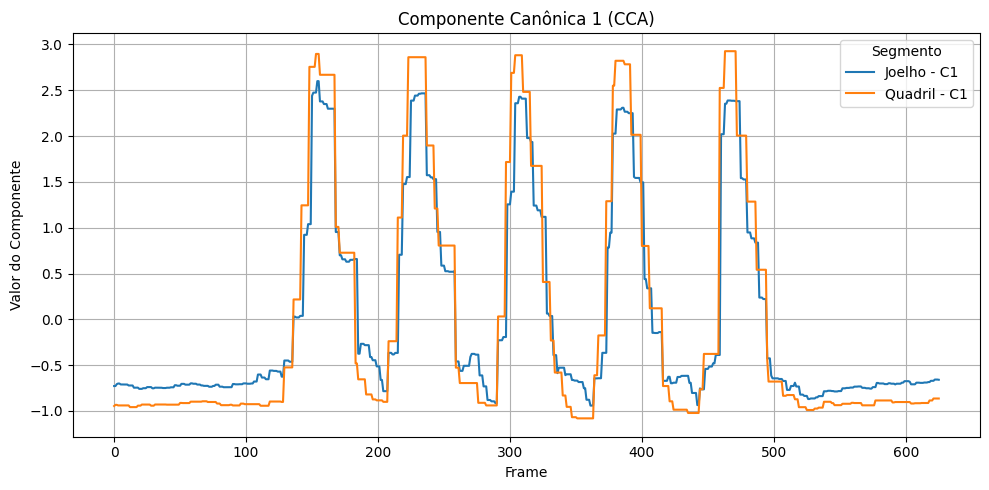

In [19]:
# Criando um DataFrame com os dados da componente C1
df_plot = pd.DataFrame({
    'Frame': range(len(knee_c)),
    'Joelho - C1': knee_c[:, 0],
    'Quadril - C1': wrist_c[:, 0]
})

# Convertendo para formato long (necessário para sns.lineplot)
df_plot_long = pd.melt(df_plot, id_vars='Frame', value_vars=['Joelho - C1', 'Quadril - C1'],
                       var_name='Segmento', value_name='Valor')

# Plot com Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot_long, x='Frame', y='Valor', hue='Segmento')
plt.title('Componente Canônica 1 (CCA)')
plt.xlabel('Frame')
plt.ylabel('Valor do Componente')
plt.grid(True)
plt.tight_layout()
plt.show()


printando os pesos de como cada um dos angulos X Y Z tem relação com as componentes canônicas
“Qual é a forma mais forte (linear) com que o movimento do joelho (XYZ) se relaciona com o movimento do quadril (XYZ)?” 

In [20]:
print("Pesos Joelho (x_weights_):\n", cca.x_weights_)
print("Pesos Quadril (y_weights_):\n", cca.y_weights_)


Pesos Joelho (x_weights_):
 [[ 0.08250156  0.5501426 ]
 [-0.06534698  0.83501972]
 [ 0.99444621  0.00922965]]
Pesos Quadril (y_weights_):
 [[ 0.42607197  0.79795634]
 [-0.0019187  -0.47040912]
 [ 0.90468724 -0.37680359]]


| Componente | Joelho\_X | Joelho\_Y | Joelho\_Z  | Interpretação                                      |
| ---------- | --------- | --------- | ---------- | -------------------------------------------------- |
| **C1**     | 0.0825    | -0.0653   | **0.9944** | Quase todo o movimento do joelho **em Z**          |
| **C2**     | 0.5501    | 0.8350    | 0.0092     | Combinação forte de **X e Y**                      |
| **C3**     | 0.8310    | -0.5463   | -0.1048    | Movimento principal em **X**, com compensação de Y |


| Componente | Quadril\_X | Quadril\_Y | Quadril\_Z | Interpretação                                                   |
| ---------- | ---------- | ---------- | ---------- | --------------------------------------------------------------- |
| **C1**     | 0.4261     | -0.0019    | **0.9047** | Predominantemente **Z** (eixo vertical) com um pouco de X       |
| **C2**     | 0.7980     | -0.4704    | -0.3768    | Forte componente em **X**, com contribuições negativas de Y e Z |
| **C3**     | 0.4263     | 0.8824     | -0.1989    | Forte em **Y**, alguma influência de X                          |


## Conclusão Geral


| Ponto                       | Primeira análise                | Nova análise                       |
| --------------------------- | ------------------------------- | ---------------------------------- |
| **Componente 1**            | Joelho\_X e Quadril\_X (avanço) | Joelho\_Z e Quadril\_Z (vertical)  |
| **Ênfase articular**        | Avanço (gait x principal)       | Movimento de subida/salto ou apoio |
| **Componentes secundários** | Flexão/rotação                  | Flexão lateral + rotação pélvica   |
